# <p style="color: red;">**COMO SE SUPONE QUE PREDIGO EL GENERO EN BASE A LA FECHA DE LANZAMIENTO O EL COSTE DE LA PELICULA**</p>

# Imports

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, log_loss, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
import random
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler
import seaborn as sns


# Descargar dataset

In [406]:
#!kaggle datasets download ashpalsingh1525/imdb-movies-dataset -p . --unzip
df = pd.read_csv("imdb_movies.csv")
df.head(5)

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [407]:
df.shape

(10178, 12)

# Tratar dataset

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


## Nulos

In [409]:
df.isnull().sum()

names          0
date_x         0
score          0
genre         85
overview       0
crew          56
orig_title     0
status         0
orig_lang      0
budget_x       0
revenue        0
country        0
dtype: int64

In [410]:
df = df.dropna()

## Vamos a aplicar MultiLabelEncoder a los generos

In [411]:
df['genre'] = df['genre'].apply(lambda x: [genre.strip() for genre in x.split(',')])
df.head(5)

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"[Drama, Action]","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"[Science Fiction, Adventure, Action]",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"[Animation, Adventure, Family, Fantasy, Comedy]","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"[Animation, Comedy, Family, Adventure, Fantasy]","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,[Action],Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [412]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genre']) 

# Crear el DataFrame de los géneros en formato binario
y_df = pd.DataFrame(y, columns=mlb.classes_)

In [413]:
df = df.drop(columns=["genre"])
y_df.head(5)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Veamos la proporcion de generos que hay

In [414]:
genre_counts = y_df.sum().sort_values(ascending=False)
print(genre_counts)

Drama              3807
Comedy             2940
Action             2750
Thriller           2605
Adventure          1888
Romance            1575
Horror             1552
Animation          1454
Family             1403
Fantasy            1375
Crime              1271
Science Fiction    1258
Mystery             860
History             422
War                 281
Music               275
TV Movie            211
Documentary         199
Western             131
dtype: int64


### Vamos a aplicar Submuestro (undersapling) para quitar peso de las categorias mas abundantes

El unico inconveniente de este metodo es que vamos a perder datos

In [415]:
print(df.shape)
print(y_df.shape)

(10052, 11)
(10052, 19)


In [416]:
df = df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)
df_2 = pd.concat([df, y_df], axis=1)
df_2.head(5)

,names,date_x,score,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Creed III,03/02/2023,73.0,"After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Avatar: The Way of Water,12/15/2022,78.0,Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,The Super Mario Bros. Movie,04/05/2023,76.0,"While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,Mummies,01/05/2023,70.0,"Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,Supercell,03/17/2023,61.0,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [417]:
df_2.isnull().sum()

names              0
date_x             0
score              0
overview           0
crew               0
orig_title         0
status             0
orig_lang          0
budget_x           0
revenue            0
country            0
Action             0
Adventure          0
Animation          0
Comedy             0
Crime              0
Documentary        0
Drama              0
Family             0
Fantasy            0
History            0
Horror             0
Music              0
Mystery            0
Romance            0
Science Fiction    0
TV Movie           0
Thriller           0
War                0
Western            0
dtype: int64

In [418]:
genre_names = y_df.columns
df_2["num_genres"] = y_df.sum(axis=1)

# Hacer submuestreo manteniendo la distribución de géneros
df_balanced = df_2.groupby("num_genres", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 131), random_state=42)
)

df_balanced = df_balanced.drop(columns=["num_genres"]).reset_index(drop=True)

C:\Users\marco\AppData\Local\Temp\ipykernel_3296\2936657107.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_2.groupby("num_genres", group_keys=False).apply(


In [419]:
X = df_balanced.drop(columns=genre_names)
y = df_balanced[genre_names]
print(X.isnull().sum())

names         0
date_x        0
score         0
overview      0
crew          0
orig_title    0
status        0
orig_lang     0
budget_x      0
revenue       0
country       0
dtype: int64


In [420]:
genre_counts = y.sum().sort_values(ascending=False)
print(genre_counts)

Comedy             302
Action             281
Adventure          280
Drama              269
Animation          235
Family             231
Fantasy            208
Thriller           194
Science Fiction    128
Horror             127
Romance            109
Mystery            104
Crime               96
TV Movie            43
Music               32
History             31
War                 26
Documentary         12
Western             10
dtype: int64


Tambien se ha reducido el numero de Wastern, debido a que peliculas que tenian generos mas populares han sido descartadas y tambien tenian Wastern como genero

### Fecha (Object &rarr; Int) (segundos desde 1970)

In [421]:
X['date_x'] = X['date_x'].str.strip()
X['date_x'] = pd.to_datetime(X['date_x'], format='%m/%d/%Y')
X['date_x'] = X['date_x'].astype('int64') // 10**9

In [422]:
X["date_x"].head(5)

0    1074729600
1    1396310400
2     711849600
3    1624838400
4     125107200
Name: date_x, dtype: int64

### Ahora vamos a normalizarlo

In [423]:
scaler = MinMaxScaler()
X["date_x"] = scaler.fit_transform(X[["date_x"]])

### Vamos a convertir el texto de "overview" en una representacion numerica usando TF-IDF
<p style="color: red;">Descartado por no tener 10 odernadores de la NASA</p> 

In [424]:
X = X.drop(columns=["overview"])
X = X.drop(columns=["crew"])

### Score

In [425]:
X["score"].min(), X["score"].max()

(0.0, 100.0)

Vamos a hacer una escala del 0 al 10 sin decimales, nos va a servir en un futuro

In [426]:
X['score'] = (X['score'] / 10).astype(int)

### Vamos a eliminar las columnas identificativas

In [427]:
X = X.drop(columns=["names", "orig_title"])

### Columna status

In [428]:
X["status"].unique()

array([' Released', ' Post Production', ' In Production'], dtype=object)

Esta columna muestra el estado actual de la pelicula: released, post production e in progress, vamos a comprobar su correlacion con los generos generos

In [429]:
le = LabelEncoder()
X["status_encoded"] = le.fit_transform(X["status"])
correlation_matrix = y_df.corrwith(X["status_encoded"])
print(correlation_matrix.sort_values(ascending=False))


Action             0.052503
Thriller           0.038951
Science Fiction    0.031146
Crime              0.021970
Mystery            0.020441
Romance            0.020266
History            0.013673
War                0.009572
Animation          0.008796
Documentary        0.008176
TV Movie           0.007790
Music              0.007386
Western            0.006019
Comedy            -0.011193
Drama             -0.012070
Horror            -0.033418
Adventure         -0.048243
Fantasy           -0.069662
Family            -0.143044
dtype: float64


Como vemos no tiene correlacion alguna con los generos, asi que podemos prescindir de ella

In [430]:
X = X.drop(columns=["status_encoded", "status"])

In [431]:
X.head(5)

,date_x,score,orig_lang,budget_x,revenue,country
0,0.786113,5,English,40000000.0,46176322.0,AU
1,0.897703,6,English,8000000.0,97708392.4,US
2,0.660191,6,English,8000000.0,2275557.0,AU
3,0.977004,6,English,80200000.0,338842741.4,GB
4,0.456587,5,Italian,118600000.0,245108932.8,IT


## revenue y budget_x

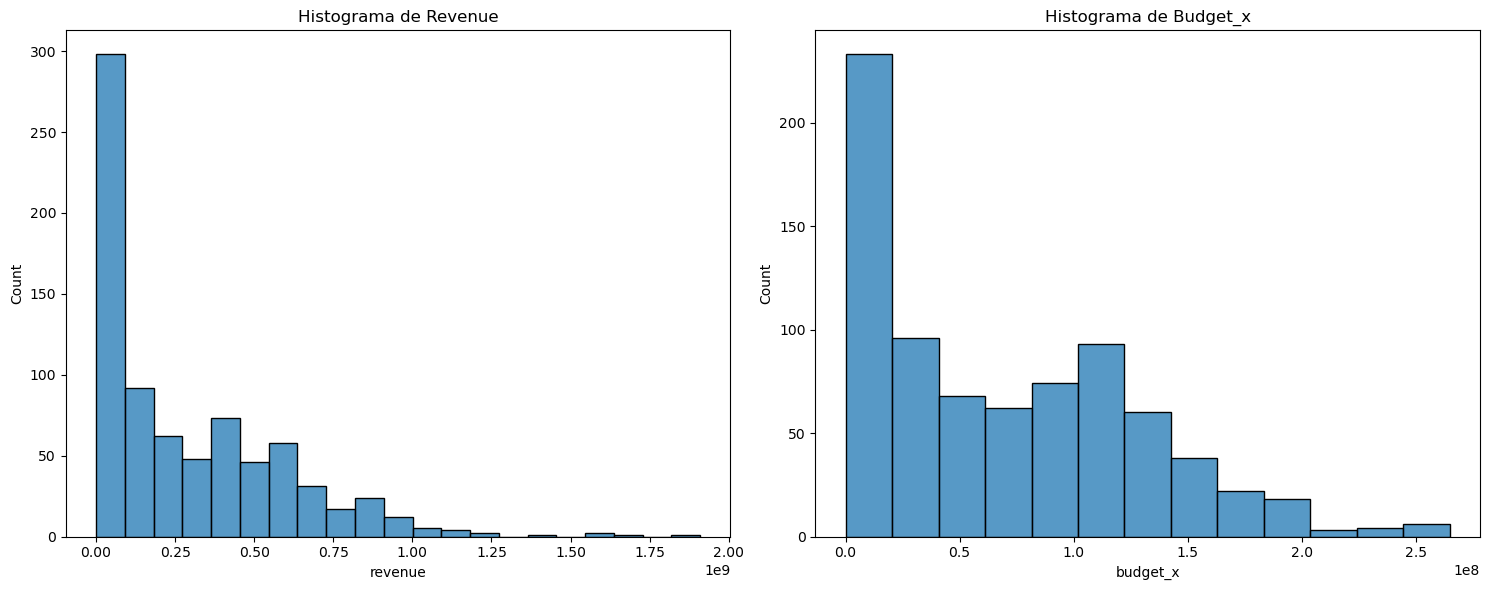

In [432]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(X["revenue"])
plt.title('Histograma de Revenue')

plt.subplot(1, 2, 2)
sns.histplot(X["budget_x"])
plt.title('Histograma de Budget_x')

plt.tight_layout()
plt.show()


In [433]:
X['revenue'][X['revenue'] == 0]

140    0.0
365    0.0
641    0.0
740    0.0
Name: revenue, dtype: float64

Simplemente hay muchas peliculas con pocos ingresos y presupuesto

# Aplicamos LabelEncoding a la region y el idioma original

In [434]:
X["country"] = le.fit_transform(X["country"])
X["orig_lang"] = le.fit_transform(X["orig_lang"])

In [435]:
X.head(2)

,date_x,score,orig_lang,budget_x,revenue,country
0,0.786113,5,4,40000000.0,46176322.0,1
1,0.897703,6,4,8000000.0,97708392.4,27


In [436]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

modelo = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(19, activation="softmax")
])

modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
modelo.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0937 - loss: 91202728.0000 - val_accuracy: 0.1538 - val_loss: 133640088.0000
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1466 - loss: 199543104.0000 - val_accuracy: 0.1154 - val_loss: 637854784.0000
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1239 - loss: 833545856.0000 - val_accuracy: 0.0577 - val_loss: 2306369024.0000
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1407 - loss: 2714628352.0000 - val_accuracy: 0.0705 - val_loss: 6084728832.0000
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1146 - loss: 6819279360.0000 - val_accuracy: 0.0064 - val_loss: 12375132160.0000
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0745 - loss: 11943042048.0000 - val_accuracy: 0.3526 - val_loss: 20532436992.0000
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1162 - loss: 19627870208.0000 - val_accuracy: 0.0705 - val_loss: 2862041907

In [437]:
# Realizar las predicciones
y_pred_prob = modelo.predict(X_test)

# Convertir las probabilidades a etiquetas binarias (0 o 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculo de las métricas
subset_accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='samples')
recall = recall_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f"Subset Accuracy: {subset_accuracy:.2f}")
print(f"Hamming Loss: {hamming}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Subset Accuracy: 0.06
Hamming Loss: 0.20512820512820512
Precision: 0.3525641025641026
Recall: 0.138743894993895
F1 Score: 0.180026455026455


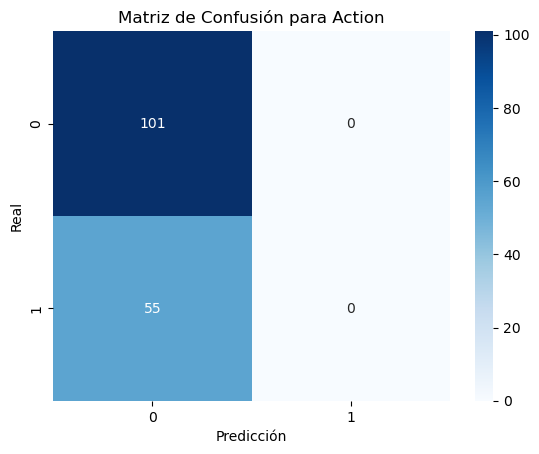

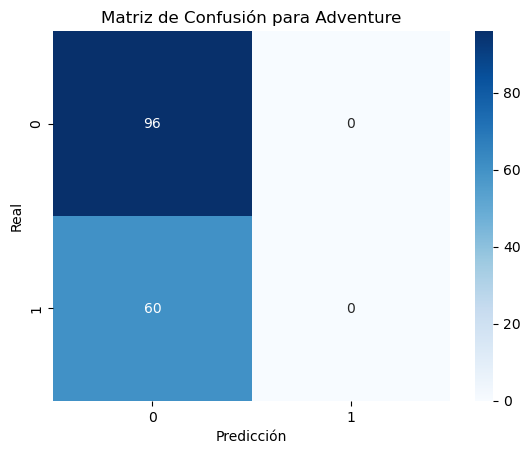

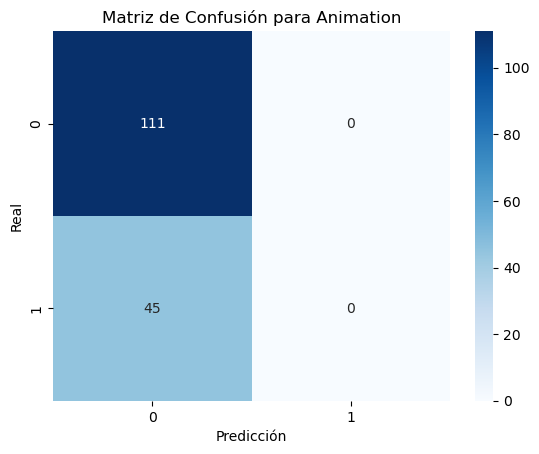

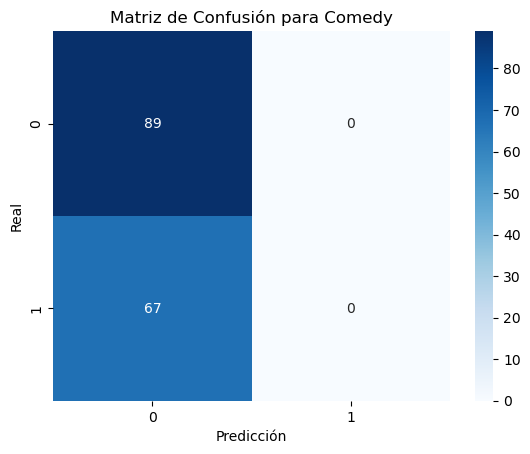

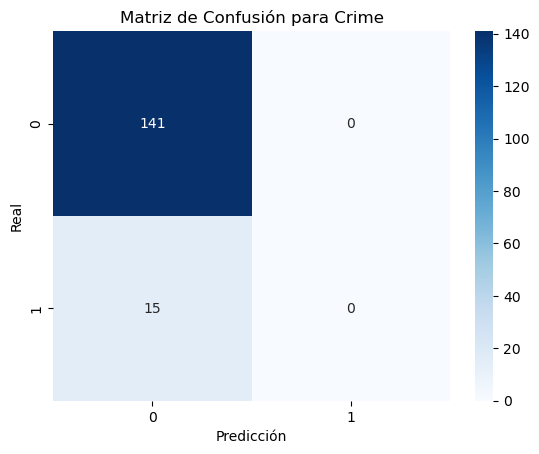

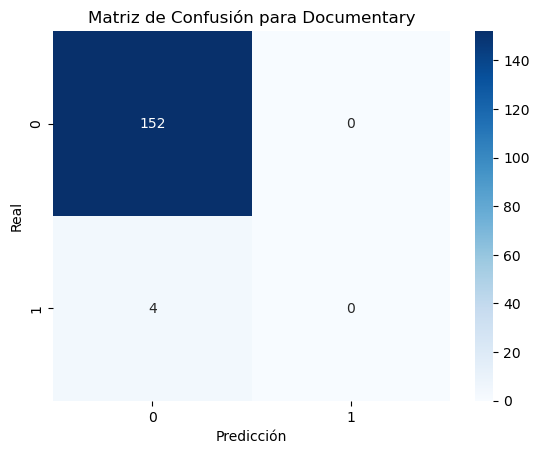

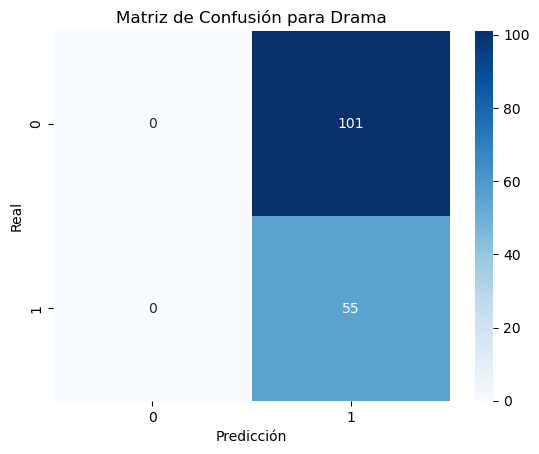

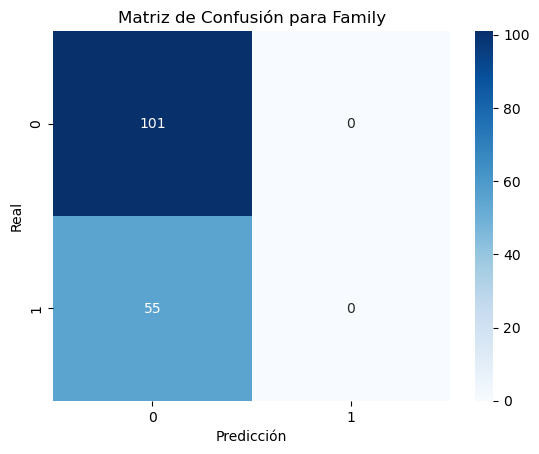

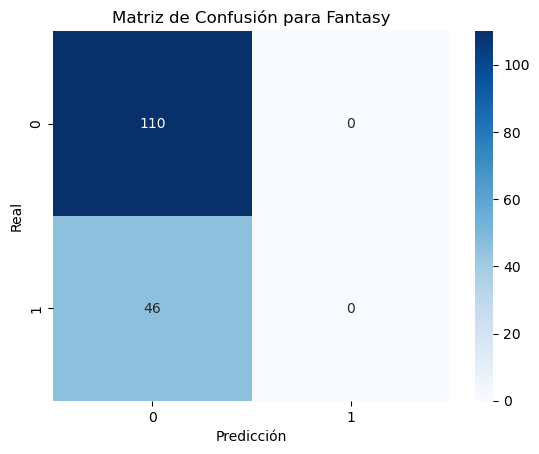

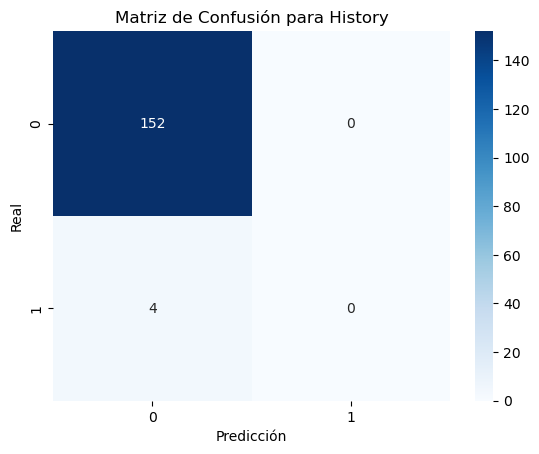

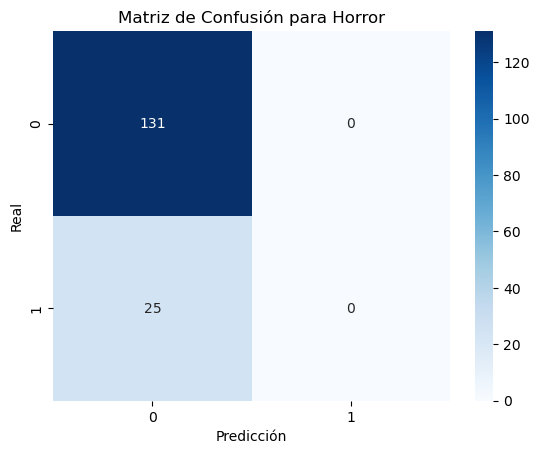

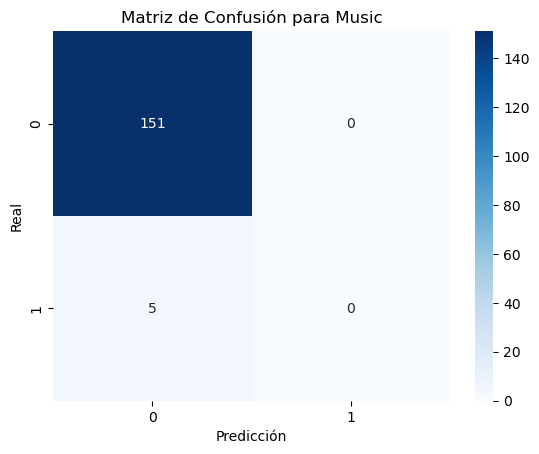

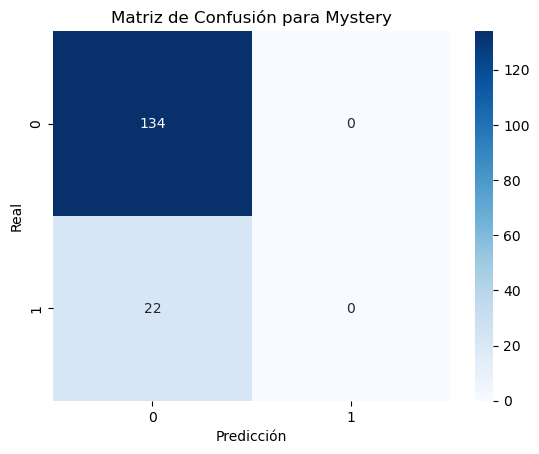

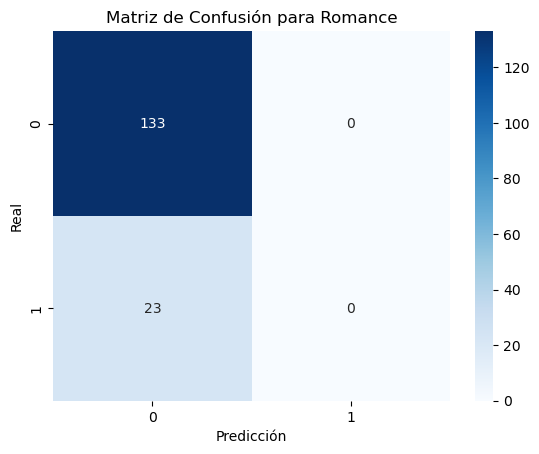

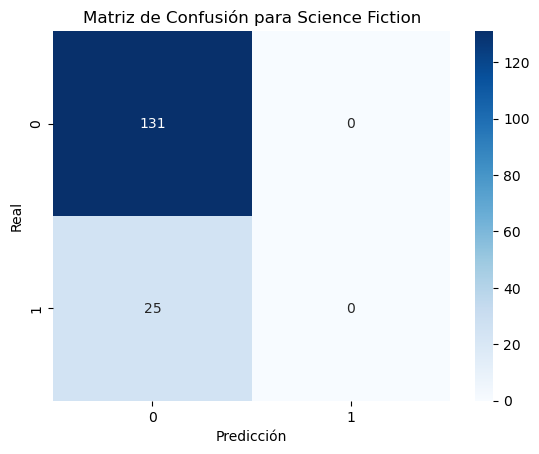

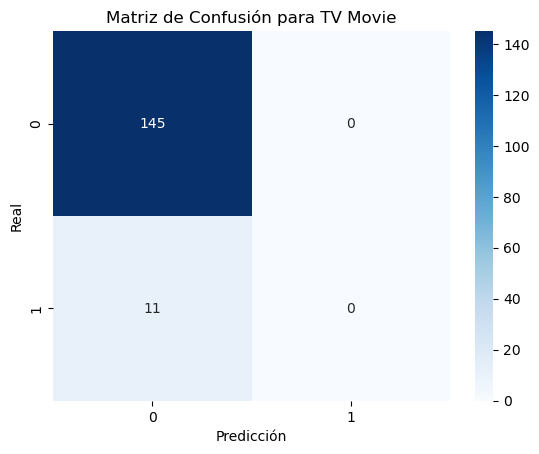

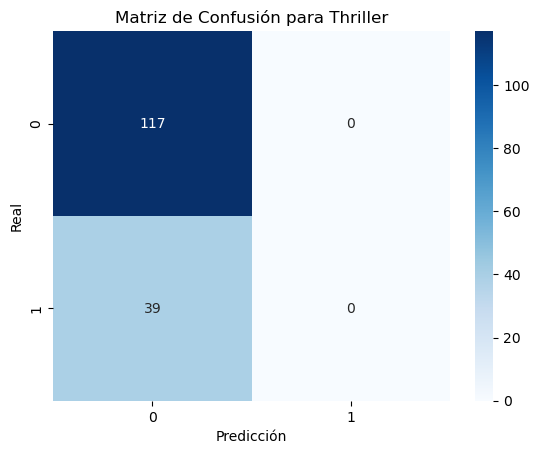

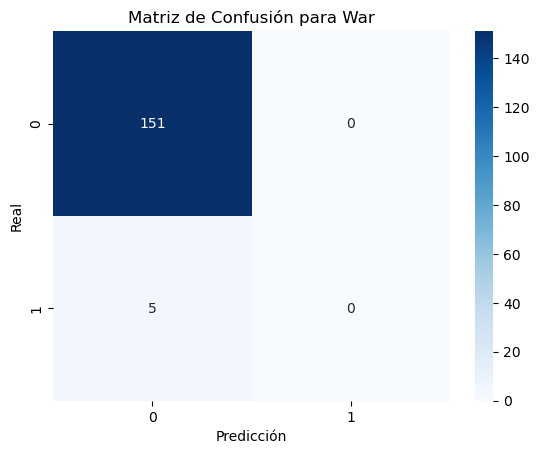

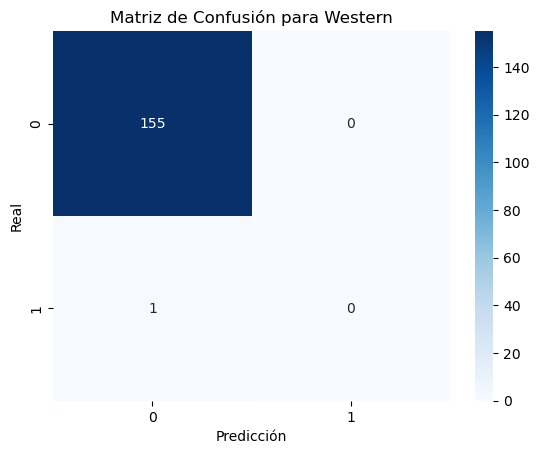

In [438]:
for i, label in enumerate(y.columns):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matriz de Confusión para {label}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()